In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [3]:
df=pd.read_csv("data.csv",encoding='big5')
df=df[df.index%2==1]
df06=df[df['機台號']=="h06"]
df14=df[df['機台號']=="h14"]
df1G=pd.concat([df06,df14],axis=0)
df01=df[df['機台號']=="h01"]
df02=df[df['機台號']=="h02"]
df08=df[df['機台號']=="h08"]
df10=df[df['機台號']=="h10"]
df15=df[df['機台號']=="h15"]
df19=df[df['機台號']=="h19"]
df10G=pd.concat([df01,df02,df08,df10,df15,df19],axis=0)
X1G=df1G[['OEE','良率']]
y1G=df1G[['產能']]
df.sort_values(by=['生產日期','機台號'], inplace = True)
df.reset_index(drop=True, inplace=True)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
df

,生產日期,機台號,班別,產能,OEE,良率
0,2022-12-13,h01,D,1918,72.9,94.3
1,2022-12-13,h01,N,0,0.0,0.0
2,2022-12-13,h02,D,2137,81.2,94.8
3,2022-12-13,h02,N,0,0.0,0.0
4,2022-12-13,h06,D,1956,63.5,84.1
...,...,...,...,...,...,...
219,2022-12-26,h14,N,2174,70.6,91.7
220,2022-12-26,h15,D,0,0.0,0.0
221,2022-12-26,h15,N,0,0.0,0.0
222,2022-12-26,h19,D,1986,75.5,93.3


In [105]:
def getData(df, column, train_end=-300, days_before=30, return_all=True, generate_index=False):
    series = df[column].copy()
    train_series, test_series = series[:train_end], series[train_end - days_before:]
    train_data = pd.DataFrame()
    for i in range(days_before):
        train_data['c%d' % i] = train_series.tolist()[i*16: -days_before*16 + i*16]
    train_data['y'] = train_series.tolist()[days_before*16:]
    
    if generate_index:
        train_data.index = train_series.index[n:]
                
    if return_all:
        return train_data, series, df.index.tolist()
    
    return train_data

In [106]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=64,
            num_layers=1, 
            batch_first=True)
        
        self.out = nn.Sequential(
            nn.Linear(64,1))
        
    def forward(self, x):
        r_out, (h_n, h_c) = self.lstm(x, None)
        out = self.out(r_out[:, -1, :])
        
        return out

In [107]:
class TrainSet(Dataset):
    def __init__(self, data):
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [112]:
LR = 0.0001
EPOCH = 150
TRAIN_END=-5
DAYS_BEFORE=10

In [7]:
df06.reset_index(drop=True, inplace=True)
df14.reset_index(drop=True, inplace=True)
df01=df01[df01.index%4==1]
df01.reset_index(drop=True, inplace=True)

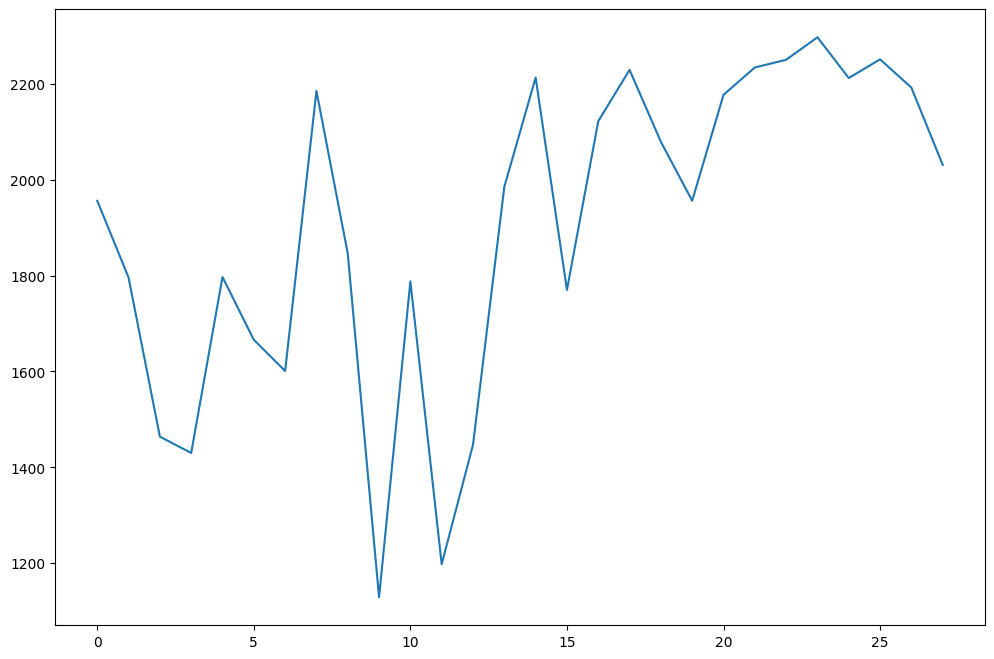

In [8]:
train_data, all_series, df_index = getData(df06, '產能', days_before=DAYS_BEFORE, train_end=TRAIN_END)

all_series = np.array(all_series.tolist())
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')

train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

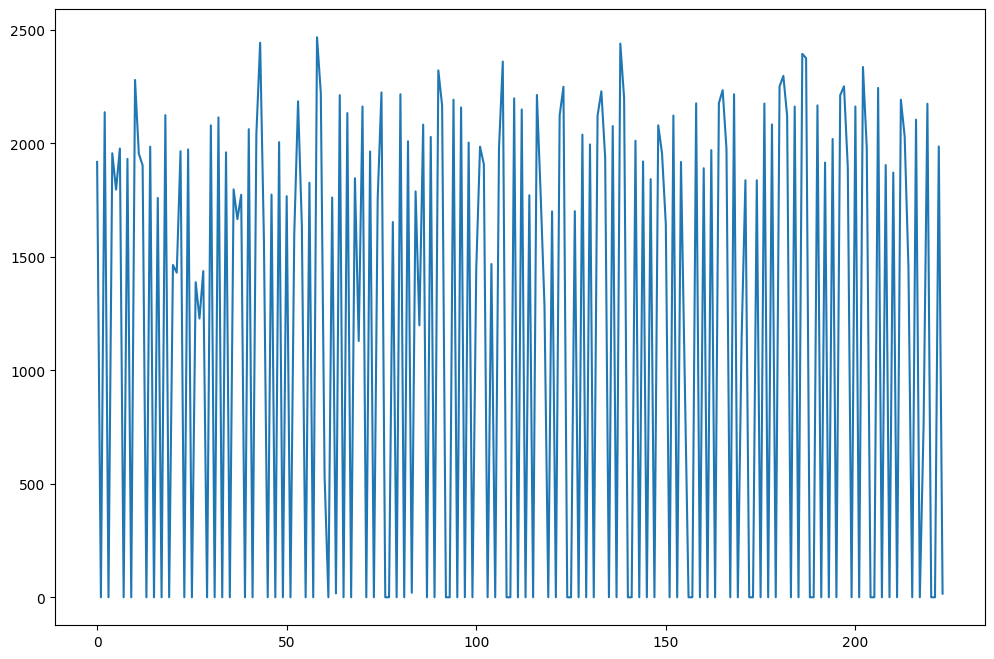

In [113]:
train_data, all_series, df_index = getData(df, '產能', days_before=DAYS_BEFORE, train_end=TRAIN_END)
all_series = np.array(all_series.tolist())
plt.figure(figsize=(12,8))
plt.plot(df_index, all_series, label='real-data')

train_data_numpy = np.array(train_data)
train_mean = np.mean(train_data_numpy)
train_std  = np.std(train_data_numpy)
train_data_numpy = (train_data_numpy - train_mean) / train_std
train_data_tensor = torch.Tensor(train_data_numpy)

train_set = TrainSet(train_data_tensor)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

In [114]:
rnn = LSTM()

if torch.cuda.is_available():
    rnn = rnn.cuda()

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in train_loader:
        
        if torch.cuda.is_available():
            tx = tx.cuda()
            ty = ty.cuda()
        output = rnn(torch.unsqueeze(tx, dim=2))
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(step, loss.cpu())
    if step % 10:
        torch.save(rnn, 'rnn.pkl')
torch.save(rnn, 'rnn.pkl')

0 tensor(1.1516, grad_fn=<ToCopyBackward0>)
1 tensor(1.2706, grad_fn=<ToCopyBackward0>)
2 tensor(1.0776, grad_fn=<ToCopyBackward0>)
3 tensor(1.0523, grad_fn=<ToCopyBackward0>)
4 tensor(1.2373, grad_fn=<ToCopyBackward0>)
5 tensor(1.2404, grad_fn=<ToCopyBackward0>)
6 tensor(1.1796, grad_fn=<ToCopyBackward0>)
7 tensor(0.8405, grad_fn=<ToCopyBackward0>)
8 tensor(1.1864, grad_fn=<ToCopyBackward0>)
9 tensor(1.0188, grad_fn=<ToCopyBackward0>)
10 tensor(0.7759, grad_fn=<ToCopyBackward0>)
11 tensor(1.1163, grad_fn=<ToCopyBackward0>)
12 tensor(1.0920, grad_fn=<ToCopyBackward0>)
13 tensor(1.0737, grad_fn=<ToCopyBackward0>)
14 tensor(0.9435, grad_fn=<ToCopyBackward0>)
15 tensor(0.9238, grad_fn=<ToCopyBackward0>)
16 tensor(0.7275, grad_fn=<ToCopyBackward0>)
17 tensor(0.9355, grad_fn=<ToCopyBackward0>)
18 tensor(1.0503, grad_fn=<ToCopyBackward0>)
19 tensor(0.8056, grad_fn=<ToCopyBackward0>)
20 tensor(0.9776, grad_fn=<ToCopyBackward0>)
21 tensor(0.8012, grad_fn=<ToCopyBackward0>)
22 tensor(0.9736, gr

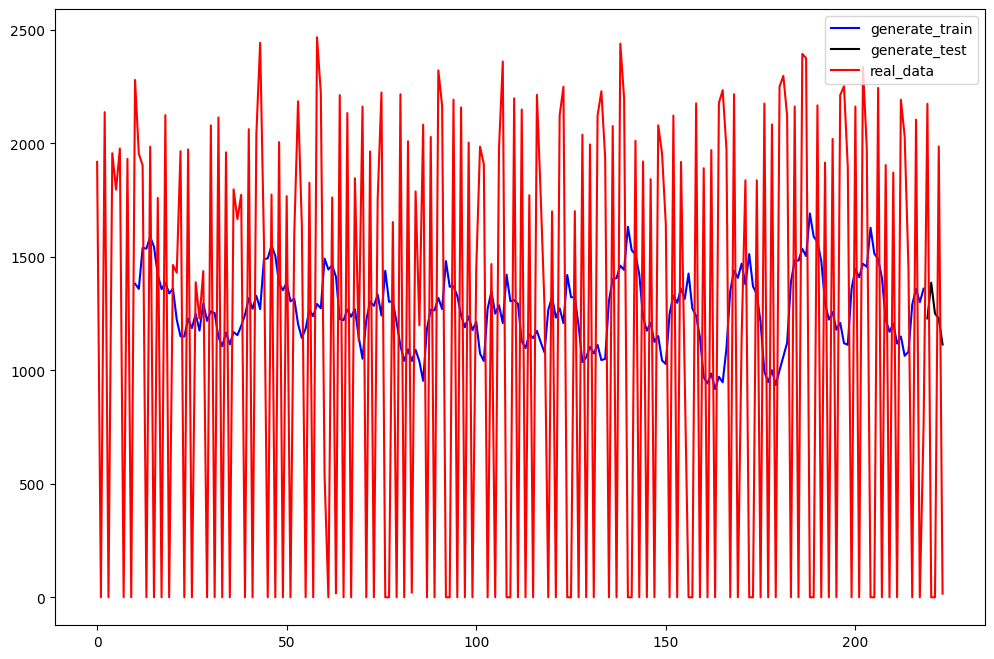

In [115]:
generate_data_train = []
generate_data_test = []

test_start = len(all_series) + TRAIN_END

all_series = (all_series - train_mean) / train_std
all_series = torch.Tensor(all_series)

for i in range(DAYS_BEFORE, len(all_series)):
    x = all_series[i - DAYS_BEFORE:i]
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=2)
    
    if torch.cuda.is_available():
        x = x.cuda()

    y = rnn(x)
    
    if i < test_start:
        generate_data_train.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
    else:
        generate_data_test.append(torch.squeeze(y.cpu()).detach().numpy() * train_std + train_mean)
        
plt.figure(figsize=(12,8))
plt.plot(df_index[DAYS_BEFORE: TRAIN_END], generate_data_train, 'b', label='generate_train', )
plt.plot(df_index[TRAIN_END:], generate_data_test, 'k', label='generate_test')
plt.plot(df_index, all_series.clone().numpy()* train_std + train_mean, 'r', label='real_data')
plt.legend()
plt.show()

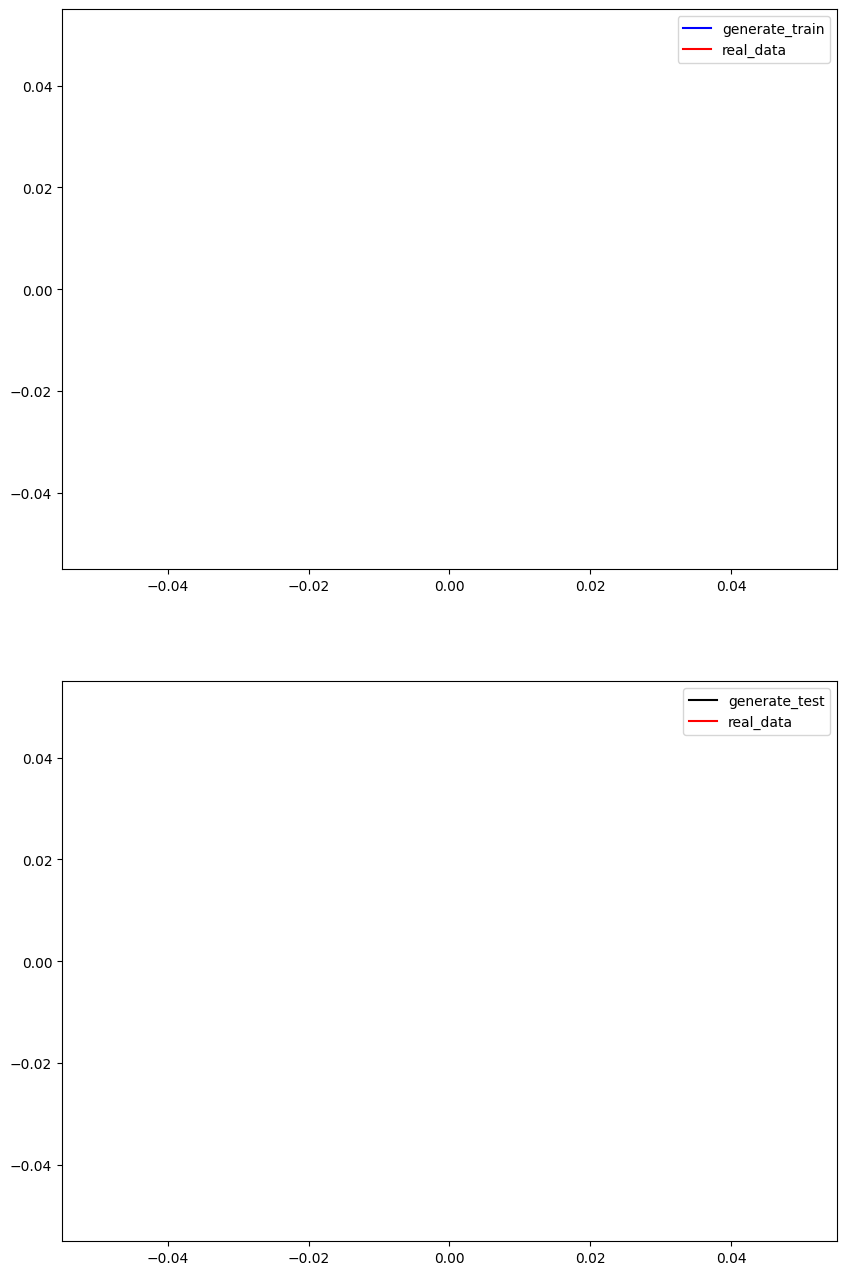

In [133]:
plt.figure(figsize=(10,16))

plt.subplot(2,1,1)
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], generate_data_train[100: 130], 'b', label='generate_train')
plt.plot(df_index[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], (all_series.clone().numpy()* train_std + train_mean)[100 + DAYS_BEFORE: 130 + DAYS_BEFORE], 'r', label='real_data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], generate_data_test[50:80], 'k', label='generate_test')
plt.plot(df_index[TRAIN_END + 50: TRAIN_END + 80], (all_series.clone().numpy()* train_std + train_mean)[TRAIN_END + 50: TRAIN_END + 80], 'r', label='real_data')
plt.legend()

plt.show()

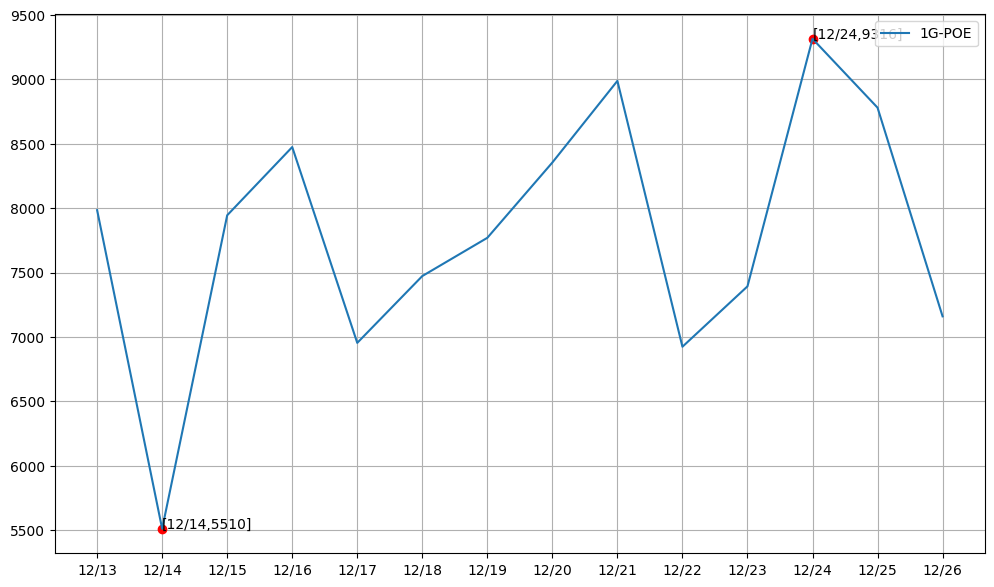

In [18]:
date_index=[f'12/{x}' for x in range(13,27)]
sumProduct=[]
for i in range(13,27):
    sumProduct.append(sum(df1G[df1G['生產日期']==f'2022-12-{i}']['產能']))
max_index=np.argmax(sumProduct)
min_index=np.argmin(sumProduct)
max_label=f'[12/{13+max_index},{sumProduct[max_index]}]'
min_label=f'[12/{13+min_index},{sumProduct[min_index]}]'
plt.figure(figsize=(12,7))
plt.grid()
plt.annotate(max_label,xytext=(max_index,sumProduct[max_index]),xy=(max_index,sumProduct[max_index]))
plt.annotate(min_label,xytext=(min_index,sumProduct[min_index]),xy=(min_index,sumProduct[min_index]))
plt.plot(max_index,sumProduct[max_index],'ro')
plt.plot(min_index,sumProduct[min_index],'ro')
plt.plot(date_index,sumProduct,label='1G-POE')
plt.legend()

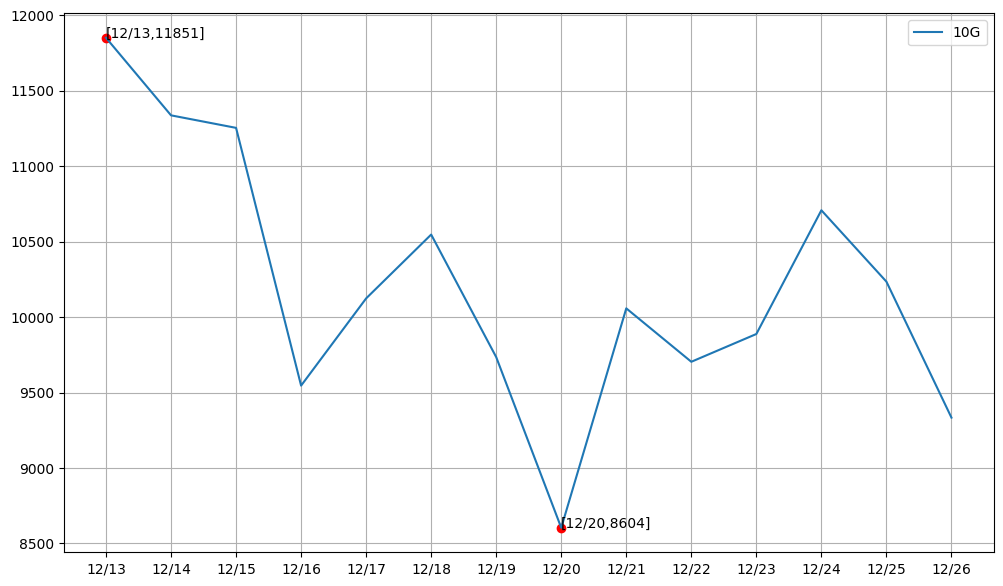

In [5]:
date_index=[f'12/{x}' for x in range(13,27)]
sumProduct=[]
for i in range(13,27):
    sumProduct.append(sum(df10G[df10G['生產日期']==f'2022-12-{i}']['產能']))
max_index=np.argmax(sumProduct)
min_index=np.argmin(sumProduct)
max_label=f'[12/{13+max_index},{sumProduct[max_index]}]'
min_label=f'[12/{13+min_index},{sumProduct[min_index]}]'
plt.figure(figsize=(12,7))
plt.grid()
plt.annotate(max_label,xytext=(max_index,sumProduct[max_index]),xy=(max_index,sumProduct[max_index]))
plt.annotate(min_label,xytext=(min_index,sumProduct[min_index]),xy=(min_index,sumProduct[min_index]))
plt.plot(max_index,sumProduct[max_index],'ro')
plt.plot(min_index,sumProduct[min_index],'ro')
plt.plot(date_index,sumProduct,label='10G')
plt.legend()

In [36]:
sumProduct

[11851,
 11337,
 11254,
 9546,
 10124,
 10547,
 9735,
 8604,
 10058,
 9704,
 9888,
 10708,
 10235,
 9334]

In [28]:
df10G

,生產日期,機台號,班別,產能,OEE,良率
1,2022-12-13,h01,D,1918,72.9,94.3
3,2022-12-13,h01,N,0,0.0,0.0
5,2022-12-14,h01,D,1759,66.9,93.5
7,2022-12-14,h01,N,0,0.0,0.0
9,2022-12-15,h01,D,2114,80.4,97.2
11,2022-12-15,h01,N,0,0.0,0.0
13,2022-12-16,h01,D,2005,76.2,95.9
15,2022-12-16,h01,N,0,0.0,0.0
17,2022-12-17,h01,D,2212,84.1,94.0
19,2022-12-17,h01,N,0,0.0,0.0


In [3]:
df1G.sort_values(by=['生產日期','機台號'], inplace = True)
df1G

,生產日期,機台號,班別,產能,OEE,良率
113,2022-12-13,h06,D,1956,63.5,84.1
115,2022-12-13,h06,N,1796,58.3,87.2
281,2022-12-13,h14,D,2279,74.0,90.3
283,2022-12-13,h14,N,1954,63.4,85.5
117,2022-12-14,h06,D,1464,47.5,82.1
119,2022-12-14,h06,N,1430,46.4,82.8
285,2022-12-14,h14,D,1388,45.0,82.2
287,2022-12-14,h14,N,1228,39.9,86.4
121,2022-12-15,h06,D,1797,58.3,89.0
123,2022-12-15,h06,N,1666,54.1,92.6
